# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


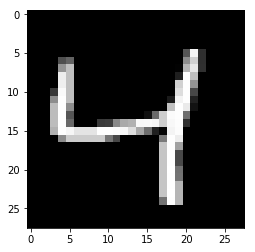

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [22]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='inputs')
targets_ = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='SAME')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='SAME')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='SAME')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [23]:
sess = tf.Session()

In [24]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7012
Epoch: 1/20... Training loss: 0.6967
Epoch: 1/20... Training loss: 0.6922
Epoch: 1/20... Training loss: 0.6883
Epoch: 1/20... Training loss: 0.6846
Epoch: 1/20... Training loss: 0.6811
Epoch: 1/20... Training loss: 0.6775
Epoch: 1/20... Training loss: 0.6742
Epoch: 1/20... Training loss: 0.6704
Epoch: 1/20... Training loss: 0.6665
Epoch: 1/20... Training loss: 0.6622
Epoch: 1/20... Training loss: 0.6574
Epoch: 1/20... Training loss: 0.6523
Epoch: 1/20... Training loss: 0.6467
Epoch: 1/20... Training loss: 0.6397
Epoch: 1/20... Training loss: 0.6325
Epoch: 1/20... Training loss: 0.6249
Epoch: 1/20... Training loss: 0.6166
Epoch: 1/20... Training loss: 0.6061
Epoch: 1/20... Training loss: 0.5975
Epoch: 1/20... Training loss: 0.5856
Epoch: 1/20... Training loss: 0.5752
Epoch: 1/20... Training loss: 0.5630
Epoch: 1/20... Training loss: 0.5491
Epoch: 1/20... Training loss: 0.5353
Epoch: 1/20... Training loss: 0.5297
Epoch: 1/20... Training loss: 0.5169
E

Epoch: 1/20... Training loss: 0.1047
Epoch: 1/20... Training loss: 0.1033
Epoch: 1/20... Training loss: 0.1024
Epoch: 1/20... Training loss: 0.1021
Epoch: 1/20... Training loss: 0.1063
Epoch: 1/20... Training loss: 0.1038
Epoch: 1/20... Training loss: 0.1023
Epoch: 1/20... Training loss: 0.1047
Epoch: 1/20... Training loss: 0.1056
Epoch: 1/20... Training loss: 0.1049
Epoch: 1/20... Training loss: 0.1024
Epoch: 1/20... Training loss: 0.1009
Epoch: 1/20... Training loss: 0.1016
Epoch: 1/20... Training loss: 0.1055
Epoch: 1/20... Training loss: 0.1036
Epoch: 1/20... Training loss: 0.1055
Epoch: 1/20... Training loss: 0.1008
Epoch: 1/20... Training loss: 0.1029
Epoch: 1/20... Training loss: 0.1007
Epoch: 1/20... Training loss: 0.0988
Epoch: 1/20... Training loss: 0.0981
Epoch: 1/20... Training loss: 0.1006
Epoch: 1/20... Training loss: 0.1019
Epoch: 1/20... Training loss: 0.0985
Epoch: 1/20... Training loss: 0.0993
Epoch: 1/20... Training loss: 0.0998
Epoch: 1/20... Training loss: 0.1035
E

Epoch: 2/20... Training loss: 0.0859
Epoch: 2/20... Training loss: 0.0846
Epoch: 2/20... Training loss: 0.0864
Epoch: 2/20... Training loss: 0.0874
Epoch: 2/20... Training loss: 0.0889
Epoch: 2/20... Training loss: 0.0862
Epoch: 2/20... Training loss: 0.0855
Epoch: 2/20... Training loss: 0.0876
Epoch: 2/20... Training loss: 0.0870
Epoch: 2/20... Training loss: 0.0850
Epoch: 2/20... Training loss: 0.0870
Epoch: 2/20... Training loss: 0.0882
Epoch: 2/20... Training loss: 0.0857
Epoch: 2/20... Training loss: 0.0862
Epoch: 2/20... Training loss: 0.0879
Epoch: 2/20... Training loss: 0.0873
Epoch: 2/20... Training loss: 0.0874
Epoch: 2/20... Training loss: 0.0824
Epoch: 2/20... Training loss: 0.0866
Epoch: 2/20... Training loss: 0.0864
Epoch: 2/20... Training loss: 0.0856
Epoch: 2/20... Training loss: 0.0848
Epoch: 2/20... Training loss: 0.0857
Epoch: 2/20... Training loss: 0.0867
Epoch: 2/20... Training loss: 0.0859
Epoch: 2/20... Training loss: 0.0864
Epoch: 2/20... Training loss: 0.0881
E

Epoch: 3/20... Training loss: 0.0817
Epoch: 3/20... Training loss: 0.0820
Epoch: 3/20... Training loss: 0.0819
Epoch: 3/20... Training loss: 0.0799
Epoch: 3/20... Training loss: 0.0809
Epoch: 3/20... Training loss: 0.0808
Epoch: 3/20... Training loss: 0.0800
Epoch: 3/20... Training loss: 0.0813
Epoch: 3/20... Training loss: 0.0820
Epoch: 3/20... Training loss: 0.0814
Epoch: 3/20... Training loss: 0.0815
Epoch: 3/20... Training loss: 0.0818
Epoch: 3/20... Training loss: 0.0831
Epoch: 3/20... Training loss: 0.0829
Epoch: 3/20... Training loss: 0.0814
Epoch: 3/20... Training loss: 0.0834
Epoch: 3/20... Training loss: 0.0822
Epoch: 3/20... Training loss: 0.0827
Epoch: 3/20... Training loss: 0.0793
Epoch: 3/20... Training loss: 0.0802
Epoch: 3/20... Training loss: 0.0806
Epoch: 3/20... Training loss: 0.0797
Epoch: 3/20... Training loss: 0.0834
Epoch: 3/20... Training loss: 0.0817
Epoch: 3/20... Training loss: 0.0821
Epoch: 3/20... Training loss: 0.0815
Epoch: 3/20... Training loss: 0.0803
E

Epoch: 3/20... Training loss: 0.0779
Epoch: 3/20... Training loss: 0.0789
Epoch: 3/20... Training loss: 0.0804
Epoch: 3/20... Training loss: 0.0795
Epoch: 3/20... Training loss: 0.0834
Epoch: 3/20... Training loss: 0.0799
Epoch: 3/20... Training loss: 0.0798
Epoch: 3/20... Training loss: 0.0794
Epoch: 3/20... Training loss: 0.0795
Epoch: 3/20... Training loss: 0.0777
Epoch: 3/20... Training loss: 0.0769
Epoch: 3/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0784
Epoch: 4/20... Training loss: 0.0783
Epoch: 4/20... Training loss: 0.0782
Epoch: 4/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0810
Epoch: 4/20... Training loss: 0.0786
Epoch: 4/20... Training loss: 0.0777
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0780
Epoch: 4/20... Training loss: 0.0778
Epoch: 4/20... Training loss: 0.0776
Epoch: 4/20... Training loss: 0.0784
Epoch: 4/20... Training loss: 0.0791
E

Epoch: 4/20... Training loss: 0.0762
Epoch: 4/20... Training loss: 0.0746
Epoch: 4/20... Training loss: 0.0804
Epoch: 4/20... Training loss: 0.0765
Epoch: 4/20... Training loss: 0.0766
Epoch: 4/20... Training loss: 0.0756
Epoch: 4/20... Training loss: 0.0768
Epoch: 4/20... Training loss: 0.0776
Epoch: 4/20... Training loss: 0.0778
Epoch: 4/20... Training loss: 0.0775
Epoch: 4/20... Training loss: 0.0793
Epoch: 4/20... Training loss: 0.0786
Epoch: 4/20... Training loss: 0.0772
Epoch: 4/20... Training loss: 0.0782
Epoch: 4/20... Training loss: 0.0777
Epoch: 4/20... Training loss: 0.0760
Epoch: 4/20... Training loss: 0.0779
Epoch: 4/20... Training loss: 0.0797
Epoch: 4/20... Training loss: 0.0773
Epoch: 4/20... Training loss: 0.0764
Epoch: 4/20... Training loss: 0.0774
Epoch: 4/20... Training loss: 0.0755
Epoch: 4/20... Training loss: 0.0762
Epoch: 4/20... Training loss: 0.0761
Epoch: 4/20... Training loss: 0.0778
Epoch: 4/20... Training loss: 0.0751
Epoch: 4/20... Training loss: 0.0808
E

Epoch: 5/20... Training loss: 0.0778
Epoch: 5/20... Training loss: 0.0794
Epoch: 5/20... Training loss: 0.0737
Epoch: 5/20... Training loss: 0.0769
Epoch: 5/20... Training loss: 0.0762
Epoch: 5/20... Training loss: 0.0765
Epoch: 5/20... Training loss: 0.0759
Epoch: 5/20... Training loss: 0.0751
Epoch: 5/20... Training loss: 0.0750
Epoch: 5/20... Training loss: 0.0771
Epoch: 5/20... Training loss: 0.0754
Epoch: 5/20... Training loss: 0.0763
Epoch: 5/20... Training loss: 0.0754
Epoch: 5/20... Training loss: 0.0760
Epoch: 5/20... Training loss: 0.0773
Epoch: 5/20... Training loss: 0.0767
Epoch: 5/20... Training loss: 0.0769
Epoch: 5/20... Training loss: 0.0752
Epoch: 5/20... Training loss: 0.0741
Epoch: 5/20... Training loss: 0.0778
Epoch: 5/20... Training loss: 0.0759
Epoch: 5/20... Training loss: 0.0754
Epoch: 5/20... Training loss: 0.0765
Epoch: 5/20... Training loss: 0.0753
Epoch: 5/20... Training loss: 0.0757
Epoch: 5/20... Training loss: 0.0780
Epoch: 5/20... Training loss: 0.0747
E

Epoch: 6/20... Training loss: 0.0752
Epoch: 6/20... Training loss: 0.0776
Epoch: 6/20... Training loss: 0.0774
Epoch: 6/20... Training loss: 0.0759
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0754
Epoch: 6/20... Training loss: 0.0763
Epoch: 6/20... Training loss: 0.0760
Epoch: 6/20... Training loss: 0.0765
Epoch: 6/20... Training loss: 0.0735
Epoch: 6/20... Training loss: 0.0729
Epoch: 6/20... Training loss: 0.0731
Epoch: 6/20... Training loss: 0.0743
Epoch: 6/20... Training loss: 0.0738
Epoch: 6/20... Training loss: 0.0757
Epoch: 6/20... Training loss: 0.0743
Epoch: 6/20... Training loss: 0.0737
Epoch: 6/20... Training loss: 0.0758
Epoch: 6/20... Training loss: 0.0744
Epoch: 6/20... Training loss: 0.0779
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0762
Epoch: 6/20... Training loss: 0.0733
Epoch: 6/20... Training loss: 0.0759
Epoch: 6/20... Training loss: 0.0740
Epoch: 6/20... Training loss: 0.0741
Epoch: 6/20... Training loss: 0.0753
E

Epoch: 6/20... Training loss: 0.0751
Epoch: 6/20... Training loss: 0.0759
Epoch: 6/20... Training loss: 0.0746
Epoch: 6/20... Training loss: 0.0734
Epoch: 6/20... Training loss: 0.0709
Epoch: 6/20... Training loss: 0.0732
Epoch: 6/20... Training loss: 0.0751
Epoch: 6/20... Training loss: 0.0737
Epoch: 6/20... Training loss: 0.0753
Epoch: 6/20... Training loss: 0.0753
Epoch: 6/20... Training loss: 0.0747
Epoch: 6/20... Training loss: 0.0745
Epoch: 6/20... Training loss: 0.0746
Epoch: 6/20... Training loss: 0.0725
Epoch: 6/20... Training loss: 0.0735
Epoch: 6/20... Training loss: 0.0756
Epoch: 6/20... Training loss: 0.0735
Epoch: 6/20... Training loss: 0.0733
Epoch: 6/20... Training loss: 0.0747
Epoch: 6/20... Training loss: 0.0742
Epoch: 6/20... Training loss: 0.0727
Epoch: 6/20... Training loss: 0.0739
Epoch: 6/20... Training loss: 0.0753
Epoch: 6/20... Training loss: 0.0747
Epoch: 7/20... Training loss: 0.0725
Epoch: 7/20... Training loss: 0.0747
Epoch: 7/20... Training loss: 0.0749
E

Epoch: 7/20... Training loss: 0.0742
Epoch: 7/20... Training loss: 0.0761
Epoch: 7/20... Training loss: 0.0760
Epoch: 7/20... Training loss: 0.0735
Epoch: 7/20... Training loss: 0.0738
Epoch: 7/20... Training loss: 0.0735
Epoch: 7/20... Training loss: 0.0736
Epoch: 7/20... Training loss: 0.0730
Epoch: 7/20... Training loss: 0.0765
Epoch: 7/20... Training loss: 0.0708
Epoch: 7/20... Training loss: 0.0736
Epoch: 7/20... Training loss: 0.0759
Epoch: 7/20... Training loss: 0.0761
Epoch: 7/20... Training loss: 0.0742
Epoch: 7/20... Training loss: 0.0752
Epoch: 7/20... Training loss: 0.0740
Epoch: 7/20... Training loss: 0.0738
Epoch: 7/20... Training loss: 0.0741
Epoch: 7/20... Training loss: 0.0748
Epoch: 7/20... Training loss: 0.0737
Epoch: 7/20... Training loss: 0.0737
Epoch: 7/20... Training loss: 0.0724
Epoch: 7/20... Training loss: 0.0735
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0727
Epoch: 7/20... Training loss: 0.0737
Epoch: 7/20... Training loss: 0.0708
E

Epoch: 8/20... Training loss: 0.0725
Epoch: 8/20... Training loss: 0.0750
Epoch: 8/20... Training loss: 0.0728
Epoch: 8/20... Training loss: 0.0712
Epoch: 8/20... Training loss: 0.0736
Epoch: 8/20... Training loss: 0.0721
Epoch: 8/20... Training loss: 0.0743
Epoch: 8/20... Training loss: 0.0760
Epoch: 8/20... Training loss: 0.0708
Epoch: 8/20... Training loss: 0.0738
Epoch: 8/20... Training loss: 0.0728
Epoch: 8/20... Training loss: 0.0739
Epoch: 8/20... Training loss: 0.0733
Epoch: 8/20... Training loss: 0.0759
Epoch: 8/20... Training loss: 0.0724
Epoch: 8/20... Training loss: 0.0740
Epoch: 8/20... Training loss: 0.0727
Epoch: 8/20... Training loss: 0.0735
Epoch: 8/20... Training loss: 0.0725
Epoch: 8/20... Training loss: 0.0742
Epoch: 8/20... Training loss: 0.0738
Epoch: 8/20... Training loss: 0.0723
Epoch: 8/20... Training loss: 0.0731
Epoch: 8/20... Training loss: 0.0750
Epoch: 8/20... Training loss: 0.0727
Epoch: 8/20... Training loss: 0.0719
Epoch: 8/20... Training loss: 0.0740
E

Epoch: 9/20... Training loss: 0.0731
Epoch: 9/20... Training loss: 0.0733
Epoch: 9/20... Training loss: 0.0716
Epoch: 9/20... Training loss: 0.0723
Epoch: 9/20... Training loss: 0.0727
Epoch: 9/20... Training loss: 0.0740
Epoch: 9/20... Training loss: 0.0715
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0725
Epoch: 9/20... Training loss: 0.0708
Epoch: 9/20... Training loss: 0.0702
Epoch: 9/20... Training loss: 0.0731
Epoch: 9/20... Training loss: 0.0726
Epoch: 9/20... Training loss: 0.0724
Epoch: 9/20... Training loss: 0.0702
Epoch: 9/20... Training loss: 0.0744
Epoch: 9/20... Training loss: 0.0709
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0732
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0717
Epoch: 9/20... Training loss: 0.0728
Epoch: 9/20... Training loss: 0.0733
Epoch: 9/20... Training loss: 0.0726
Epoch: 9/20... Training loss: 0.0731
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0736
E

Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0735
Epoch: 9/20... Training loss: 0.0727
Epoch: 9/20... Training loss: 0.0716
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0752
Epoch: 9/20... Training loss: 0.0712
Epoch: 9/20... Training loss: 0.0706
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0748
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0738
Epoch: 9/20... Training loss: 0.0757
Epoch: 9/20... Training loss: 0.0710
Epoch: 9/20... Training loss: 0.0725
Epoch: 9/20... Training loss: 0.0738
Epoch: 9/20... Training loss: 0.0746
Epoch: 9/20... Training loss: 0.0715
Epoch: 9/20... Training loss: 0.0711
Epoch: 9/20... Training loss: 0.0731
Epoch: 9/20... Training loss: 0.0723
Epoch: 9/20... Training loss: 0.0742
Epoch: 9/20... Training loss: 0.0717
Epoch: 9/20... Training loss: 0.0730
Epoch: 9/20... Training loss: 0.0723
E

Epoch: 10/20... Training loss: 0.0708
Epoch: 10/20... Training loss: 0.0730
Epoch: 10/20... Training loss: 0.0713
Epoch: 10/20... Training loss: 0.0722
Epoch: 10/20... Training loss: 0.0711
Epoch: 10/20... Training loss: 0.0724
Epoch: 10/20... Training loss: 0.0736
Epoch: 10/20... Training loss: 0.0715
Epoch: 10/20... Training loss: 0.0758
Epoch: 10/20... Training loss: 0.0736
Epoch: 10/20... Training loss: 0.0743
Epoch: 10/20... Training loss: 0.0732
Epoch: 10/20... Training loss: 0.0708
Epoch: 10/20... Training loss: 0.0723
Epoch: 10/20... Training loss: 0.0700
Epoch: 10/20... Training loss: 0.0728
Epoch: 10/20... Training loss: 0.0735
Epoch: 10/20... Training loss: 0.0730
Epoch: 10/20... Training loss: 0.0730
Epoch: 10/20... Training loss: 0.0717
Epoch: 10/20... Training loss: 0.0717
Epoch: 10/20... Training loss: 0.0725
Epoch: 10/20... Training loss: 0.0706
Epoch: 10/20... Training loss: 0.0728
Epoch: 10/20... Training loss: 0.0719
Epoch: 10/20... Training loss: 0.0704
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0746
Epoch: 11/20... Training loss: 0.0729
Epoch: 11/20... Training loss: 0.0717
Epoch: 11/20... Training loss: 0.0726
Epoch: 11/20... Training loss: 0.0737
Epoch: 11/20... Training loss: 0.0747
Epoch: 11/20... Training loss: 0.0712
Epoch: 11/20... Training loss: 0.0712
Epoch: 11/20... Training loss: 0.0737
Epoch: 11/20... Training loss: 0.0724
Epoch: 11/20... Training loss: 0.0715
Epoch: 11/20... Training loss: 0.0724
Epoch: 11/20... Training loss: 0.0717
Epoch: 11/20... Training loss: 0.0729
Epoch: 11/20... Training loss: 0.0737
Epoch: 11/20... Training loss: 0.0711
Epoch: 11/20... Training loss: 0.0722
Epoch: 11/20... Training loss: 0.0715
Epoch: 11/20... Training loss: 0.0710
Epoch: 11/20... Training loss: 0.0739
Epoch: 11/20... Training loss: 0.0707
Epoch: 11/20... Training loss: 0.0702
Epoch: 11/20... Training loss: 0.0718
Epoch: 11/20... Training loss: 0.0716
Epoch: 11/20... Training loss: 0.0720
Epoch: 11/20... Training loss: 0.0735
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0715
Epoch: 12/20... Training loss: 0.0714
Epoch: 12/20... Training loss: 0.0713
Epoch: 12/20... Training loss: 0.0719
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0695
Epoch: 12/20... Training loss: 0.0725
Epoch: 12/20... Training loss: 0.0727
Epoch: 12/20... Training loss: 0.0722
Epoch: 12/20... Training loss: 0.0725
Epoch: 12/20... Training loss: 0.0710
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0712
Epoch: 12/20... Training loss: 0.0717
Epoch: 12/20... Training loss: 0.0717
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0696
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0708
Epoch: 12/20... Training loss: 0.0713
Epoch: 12/20... Training loss: 0.0720
Epoch: 12/20... Training loss: 0.0710
Epoch: 12/20... Training loss: 0.0714
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20

KeyboardInterrupt: 

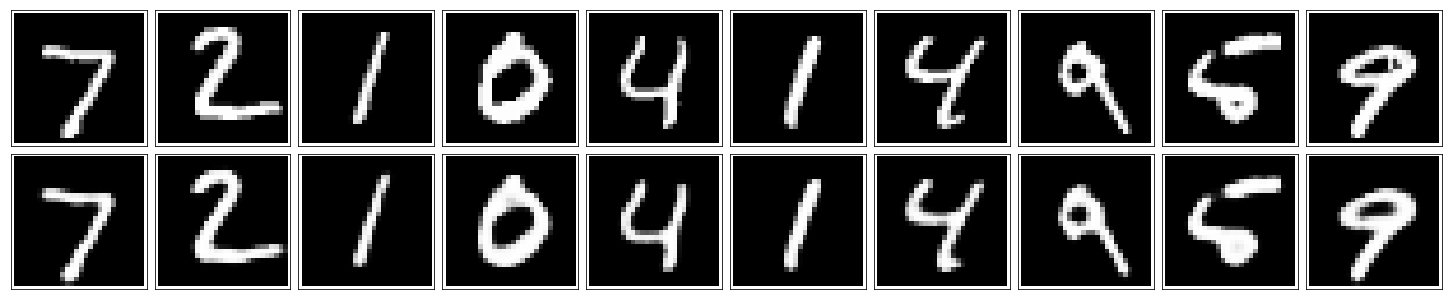

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [26]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [28]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='SAME')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='SAME')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded =  tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='SAME')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv4, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [29]:
sess = tf.Session()

In [37]:
epochs = 5
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/5... Training loss: 0.6954
Epoch: 1/5... Training loss: 0.6808
Epoch: 1/5... Training loss: 0.6663
Epoch: 1/5... Training loss: 0.6483
Epoch: 1/5... Training loss: 0.6249
Epoch: 1/5... Training loss: 0.5937
Epoch: 1/5... Training loss: 0.5568
Epoch: 1/5... Training loss: 0.5231
Epoch: 1/5... Training loss: 0.5033
Epoch: 1/5... Training loss: 0.4959
Epoch: 1/5... Training loss: 0.5219
Epoch: 1/5... Training loss: 0.5143
Epoch: 1/5... Training loss: 0.5225
Epoch: 1/5... Training loss: 0.5072
Epoch: 1/5... Training loss: 0.4746
Epoch: 1/5... Training loss: 0.4730
Epoch: 1/5... Training loss: 0.4701
Epoch: 1/5... Training loss: 0.4650
Epoch: 1/5... Training loss: 0.4659
Epoch: 1/5... Training loss: 0.4567
Epoch: 1/5... Training loss: 0.4587
Epoch: 1/5... Training loss: 0.4550
Epoch: 1/5... Training loss: 0.4444
Epoch: 1/5... Training loss: 0.4319
Epoch: 1/5... Training loss: 0.4221
Epoch: 1/5... Training loss: 0.4269
Epoch: 1/5... Training loss: 0.4133
Epoch: 1/5... Training loss:

Epoch: 1/5... Training loss: 0.1289
Epoch: 1/5... Training loss: 0.1322
Epoch: 1/5... Training loss: 0.1331
Epoch: 1/5... Training loss: 0.1288
Epoch: 1/5... Training loss: 0.1342
Epoch: 1/5... Training loss: 0.1320
Epoch: 1/5... Training loss: 0.1254
Epoch: 1/5... Training loss: 0.1301
Epoch: 1/5... Training loss: 0.1336
Epoch: 1/5... Training loss: 0.1277
Epoch: 1/5... Training loss: 0.1272
Epoch: 1/5... Training loss: 0.1286
Epoch: 1/5... Training loss: 0.1282
Epoch: 1/5... Training loss: 0.1262
Epoch: 1/5... Training loss: 0.1279
Epoch: 1/5... Training loss: 0.1275
Epoch: 1/5... Training loss: 0.1286
Epoch: 1/5... Training loss: 0.1313
Epoch: 1/5... Training loss: 0.1275
Epoch: 1/5... Training loss: 0.1338
Epoch: 1/5... Training loss: 0.1280
Epoch: 1/5... Training loss: 0.1313
Epoch: 1/5... Training loss: 0.1322
Epoch: 1/5... Training loss: 0.1243
Epoch: 1/5... Training loss: 0.1251
Epoch: 1/5... Training loss: 0.1279
Epoch: 1/5... Training loss: 0.1265
Epoch: 1/5... Training loss:

Epoch: 2/5... Training loss: 0.1218
Epoch: 2/5... Training loss: 0.1235
Epoch: 2/5... Training loss: 0.1174
Epoch: 2/5... Training loss: 0.1221
Epoch: 2/5... Training loss: 0.1235
Epoch: 2/5... Training loss: 0.1189
Epoch: 2/5... Training loss: 0.1229
Epoch: 2/5... Training loss: 0.1190
Epoch: 2/5... Training loss: 0.1202
Epoch: 2/5... Training loss: 0.1205
Epoch: 2/5... Training loss: 0.1168
Epoch: 2/5... Training loss: 0.1223
Epoch: 2/5... Training loss: 0.1200
Epoch: 2/5... Training loss: 0.1164
Epoch: 2/5... Training loss: 0.1242
Epoch: 2/5... Training loss: 0.1195
Epoch: 2/5... Training loss: 0.1209
Epoch: 2/5... Training loss: 0.1201
Epoch: 2/5... Training loss: 0.1202
Epoch: 2/5... Training loss: 0.1187
Epoch: 2/5... Training loss: 0.1196
Epoch: 2/5... Training loss: 0.1188
Epoch: 2/5... Training loss: 0.1156
Epoch: 2/5... Training loss: 0.1211
Epoch: 2/5... Training loss: 0.1216
Epoch: 2/5... Training loss: 0.1186
Epoch: 2/5... Training loss: 0.1177
Epoch: 2/5... Training loss:

Epoch: 3/5... Training loss: 0.1172
Epoch: 3/5... Training loss: 0.1165
Epoch: 3/5... Training loss: 0.1139
Epoch: 3/5... Training loss: 0.1168
Epoch: 3/5... Training loss: 0.1165
Epoch: 3/5... Training loss: 0.1180
Epoch: 3/5... Training loss: 0.1148
Epoch: 3/5... Training loss: 0.1169
Epoch: 3/5... Training loss: 0.1128
Epoch: 3/5... Training loss: 0.1157
Epoch: 3/5... Training loss: 0.1170
Epoch: 3/5... Training loss: 0.1169
Epoch: 3/5... Training loss: 0.1153
Epoch: 3/5... Training loss: 0.1134
Epoch: 3/5... Training loss: 0.1174
Epoch: 3/5... Training loss: 0.1156
Epoch: 3/5... Training loss: 0.1181
Epoch: 3/5... Training loss: 0.1163
Epoch: 3/5... Training loss: 0.1173
Epoch: 3/5... Training loss: 0.1161
Epoch: 3/5... Training loss: 0.1147
Epoch: 3/5... Training loss: 0.1167
Epoch: 3/5... Training loss: 0.1173
Epoch: 3/5... Training loss: 0.1168
Epoch: 3/5... Training loss: 0.1152
Epoch: 3/5... Training loss: 0.1161
Epoch: 3/5... Training loss: 0.1149
Epoch: 3/5... Training loss:

Epoch: 4/5... Training loss: 0.1114
Epoch: 4/5... Training loss: 0.1143
Epoch: 4/5... Training loss: 0.1152
Epoch: 4/5... Training loss: 0.1157
Epoch: 4/5... Training loss: 0.1129
Epoch: 4/5... Training loss: 0.1128
Epoch: 4/5... Training loss: 0.1156
Epoch: 4/5... Training loss: 0.1123
Epoch: 4/5... Training loss: 0.1112
Epoch: 4/5... Training loss: 0.1076
Epoch: 4/5... Training loss: 0.1113
Epoch: 4/5... Training loss: 0.1116
Epoch: 4/5... Training loss: 0.1141
Epoch: 4/5... Training loss: 0.1155
Epoch: 4/5... Training loss: 0.1156
Epoch: 4/5... Training loss: 0.1120
Epoch: 4/5... Training loss: 0.1107
Epoch: 4/5... Training loss: 0.1126
Epoch: 4/5... Training loss: 0.1155
Epoch: 4/5... Training loss: 0.1161
Epoch: 4/5... Training loss: 0.1171
Epoch: 4/5... Training loss: 0.1128
Epoch: 4/5... Training loss: 0.1144
Epoch: 4/5... Training loss: 0.1121
Epoch: 4/5... Training loss: 0.1147
Epoch: 4/5... Training loss: 0.1086
Epoch: 4/5... Training loss: 0.1107
Epoch: 4/5... Training loss:

Epoch: 4/5... Training loss: 0.1123
Epoch: 4/5... Training loss: 0.1093
Epoch: 4/5... Training loss: 0.1124
Epoch: 4/5... Training loss: 0.1108
Epoch: 4/5... Training loss: 0.1110
Epoch: 4/5... Training loss: 0.1160
Epoch: 4/5... Training loss: 0.1143
Epoch: 4/5... Training loss: 0.1123
Epoch: 4/5... Training loss: 0.1104
Epoch: 4/5... Training loss: 0.1106
Epoch: 4/5... Training loss: 0.1095
Epoch: 4/5... Training loss: 0.1084
Epoch: 4/5... Training loss: 0.1100
Epoch: 4/5... Training loss: 0.1083
Epoch: 4/5... Training loss: 0.1119
Epoch: 4/5... Training loss: 0.1077
Epoch: 4/5... Training loss: 0.1116
Epoch: 4/5... Training loss: 0.1080
Epoch: 4/5... Training loss: 0.1110
Epoch: 4/5... Training loss: 0.1092
Epoch: 4/5... Training loss: 0.1108
Epoch: 4/5... Training loss: 0.1118
Epoch: 4/5... Training loss: 0.1118
Epoch: 4/5... Training loss: 0.1142
Epoch: 4/5... Training loss: 0.1114
Epoch: 4/5... Training loss: 0.1124
Epoch: 4/5... Training loss: 0.1100
Epoch: 4/5... Training loss:

Epoch: 5/5... Training loss: 0.1125
Epoch: 5/5... Training loss: 0.1082
Epoch: 5/5... Training loss: 0.1107
Epoch: 5/5... Training loss: 0.1117
Epoch: 5/5... Training loss: 0.1104
Epoch: 5/5... Training loss: 0.1105
Epoch: 5/5... Training loss: 0.1113
Epoch: 5/5... Training loss: 0.1108
Epoch: 5/5... Training loss: 0.1089
Epoch: 5/5... Training loss: 0.1128
Epoch: 5/5... Training loss: 0.1072
Epoch: 5/5... Training loss: 0.1133
Epoch: 5/5... Training loss: 0.1083
Epoch: 5/5... Training loss: 0.1108
Epoch: 5/5... Training loss: 0.1097
Epoch: 5/5... Training loss: 0.1125
Epoch: 5/5... Training loss: 0.1084
Epoch: 5/5... Training loss: 0.1140
Epoch: 5/5... Training loss: 0.1075
Epoch: 5/5... Training loss: 0.1119
Epoch: 5/5... Training loss: 0.1108
Epoch: 5/5... Training loss: 0.1115
Epoch: 5/5... Training loss: 0.1092
Epoch: 5/5... Training loss: 0.1115
Epoch: 5/5... Training loss: 0.1145
Epoch: 5/5... Training loss: 0.1109
Epoch: 5/5... Training loss: 0.1122
Epoch: 5/5... Training loss:

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

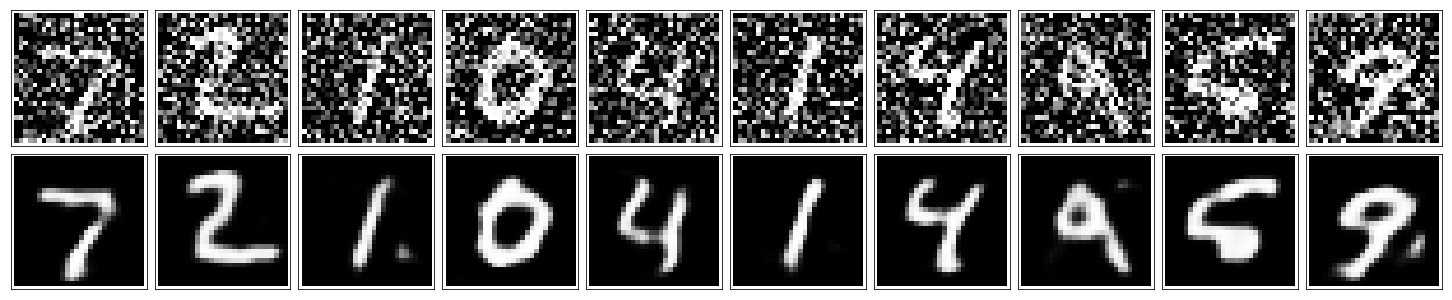

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)